In [7]:
import statsmodels
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Importing data
- Check to see that DataFrame ```industrial``` has two columns ```date``` and ```lip```
- The variable ```lip``` is the log of the seasonally adjusted industrial production index of the US ($ip=100$ in 2007).
- The sample is monthly and covers the period from 1980M1 to 2014M12 but we use the sample up to 2013M12.

In [3]:
industrial = pd.read_csv('data/industrial.csv')
industrial.index = pd.date_range(start='1980-01-01', periods= industrial.shape[0], freq='M')

# Define start and end date of sample
start = '1980-01-01'
end = '2014-01-01' 

In [4]:
industrial['constant'] = 1

industrial['time'] = np.arange(industrial.shape[0])+1

Y = industrial['lip'][start:end]
X_linear = industrial[['constant','time']][start:end]

result_linear2 = sm.OLS(Y,X_linear, missing='drop').fit()
print(result_linear2.summary())

                            OLS Regression Results                            
Dep. Variable:                    lip   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     4435.
Date:                Thu, 29 Jun 2023   Prob (F-statistic):          1.27e-220
Time:                        14:45:11   Log-Likelihood:                 503.70
No. Observations:                 408   AIC:                            -1003.
Df Residuals:                     406   BIC:                            -995.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       3.8944      0.007    556.252      0.0

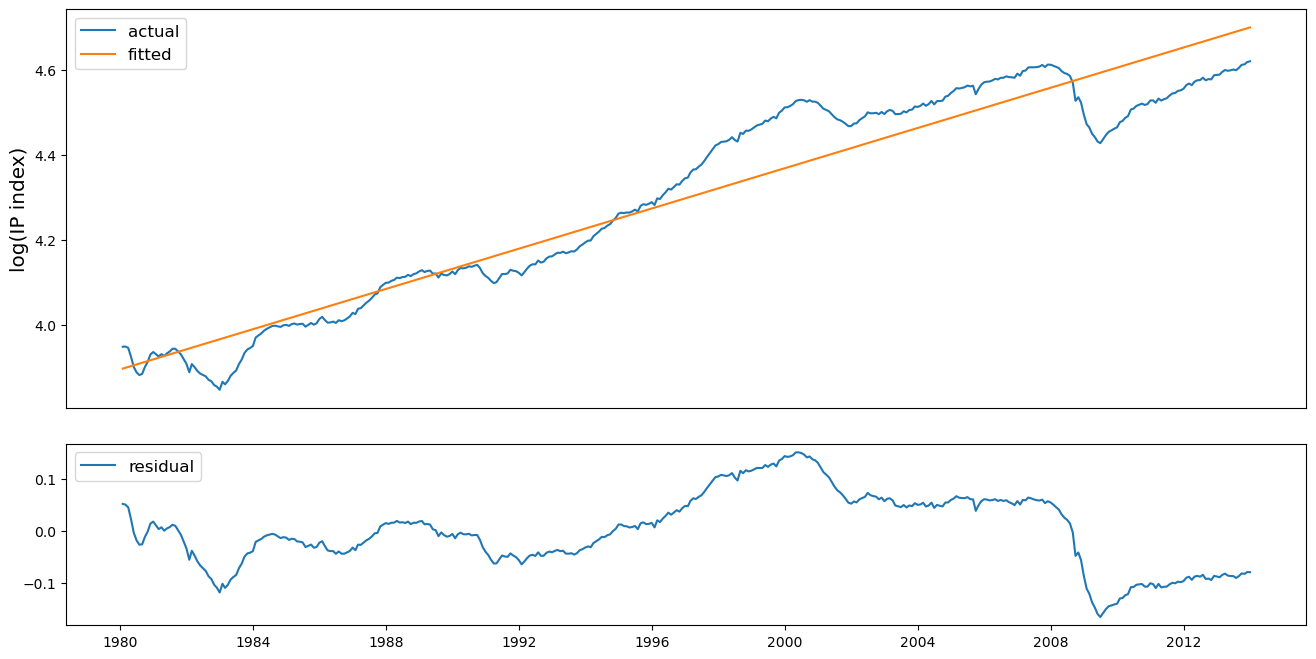

In [5]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

# Plots dependent variable Y and fitted values in the upper panel
ax1.plot(Y, label = 'actual')
ax1.plot(result_linear2.fittedvalues, label = 'fitted')

# Plots residuals in the lower panel
ax2.plot(result_linear2.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(IP index)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')
plt.show()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


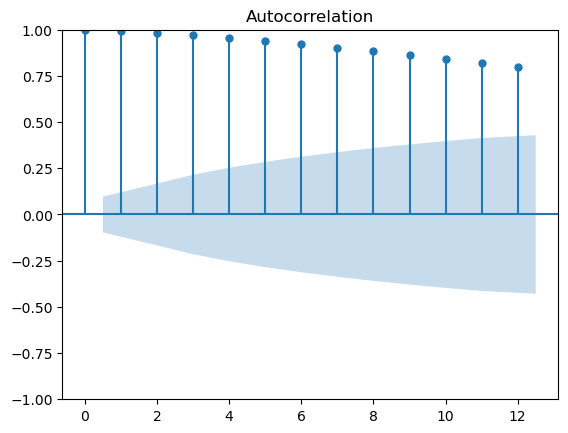

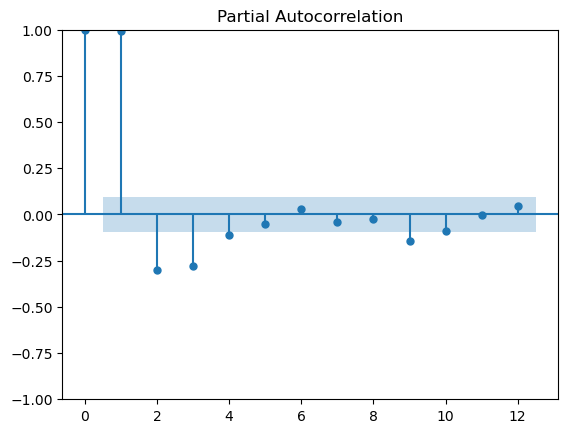

In [8]:
plot_acf(result_linear2.resid, lags=12)
plot_pacf(result_linear2.resid, lags=12)
plt.show()

The ACF gradually decreases and the PACF drops off after 1 lag. Indicative that an AR model will fit the data better.

In [11]:
X1 = X_linear

import warnings
warnings.filterwarnings("ignore")

model_sics = []
for p in range(7):
  model = ARIMA(Y, order=(p, 0, 0), exog=X1, trend='n').fit()
  sic = model.bic
  model_sics.append(sic)
  print (p, 'lag model has SIC of:', sic)

print('min SIC:', min(model_sics))

0 lag model has SIC of: -989.2698365600604
1 lag model has SIC of: -2877.4568441451074
2 lag model has SIC of: -2905.795915734446
3 lag model has SIC of: -2928.4762896884936
4 lag model has SIC of: -2936.243955132614
5 lag model has SIC of: -2933.1805599247623
6 lag model has SIC of: -2927.570432862447
min SIC: -2936.243955132614


In [12]:
#model
result_arma2 = ARIMA(Y, order=(4, 0, 0), exog=X1, trend='n').fit()
print(result_arma2.summary())

                               SARIMAX Results                                
Dep. Variable:                    lip   No. Observations:                  408
Model:                 ARIMA(4, 0, 0)   Log Likelihood                1489.161
Date:                Thu, 29 Jun 2023   AIC                          -2964.323
Time:                        14:49:21   BIC                          -2936.244
Sample:                    01-31-1980   HQIC                         -2953.212
                         - 12-31-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant       3.9311      0.088     44.572      0.000       3.758       4.104
time           0.0018      0.000      5.513      0.000       0.001       0.002
ar.L1          1.1563      0.033     34.782      0.0

In [13]:
from statsmodels.stats import stattools as st

st.durbin_watson(model.resid)

1.7853216032575452

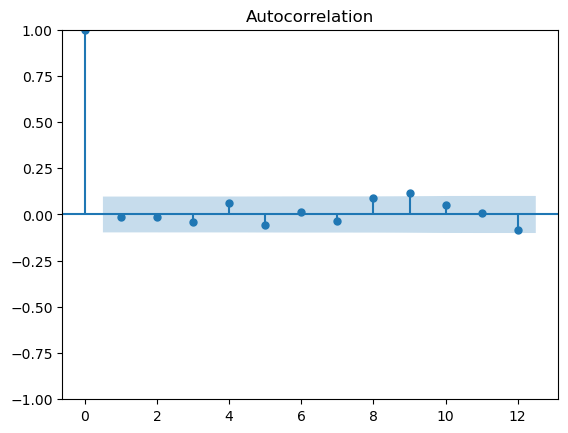

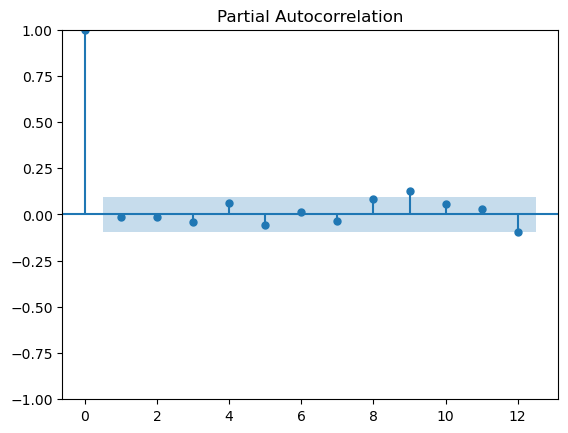

In [14]:
plot_acf(result_arma2.resid, lags=12)
plot_pacf(result_arma2.resid, lags=12)
plt.show()

In [15]:
from statsmodels.stats import diagnostic
bgtest = diagnostic.acorr_breusch_godfrey(result_arma2, nlags = 6)
print('Breusch Godfrey test LM statistic: ', bgtest[0])
print('Breusch Godfrey test LM p-value: ', bgtest[1])

Breusch Godfrey test LM statistic:  3.791350356161794
Breusch Godfrey test LM p-value:  0.7048877965961013


We do not reject the null hypothesis at the 5% level.

In [16]:
industrial['L1_lip'] = industrial['lip'].shift(1)
industrial['L2_lip'] = industrial['lip'].shift(2)
industrial['L3_lip'] = industrial['lip'].shift(3)
industrial['L4_lip'] = industrial['lip'].shift(4)

exog = industrial[['time', 'constant', 'L1_lip', 'L2_lip', 'L3_lip', 'L4_lip']]
model = sm.RecursiveLS(industrial['lip'][4:], exog[4:])
result_rec = model.fit()
print(result_rec.summary())

                           Statespace Model Results                           
Dep. Variable:                    lip   No. Observations:                  416
Model:                    RecursiveLS   Log Likelihood                1491.288
Date:                Thu, 29 Jun 2023   R-squared:                       0.999
Time:                        14:51:40   AIC                          -2970.576
Sample:                    05-31-1980   BIC                          -2946.392
                         - 12-31-2014   HQIC                         -2961.014
Covariance Type:            nonrobust   Scale                            0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
time        1.541e-05   8.88e-06      1.735      0.083      -2e-06    3.28e-05
constant       0.0337      0.017      1.987      0.047       0.000       0.067
L1_lip         1.1450      0.048     23.858      0.0

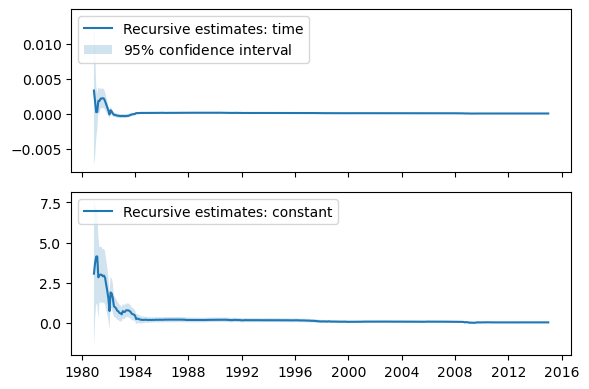

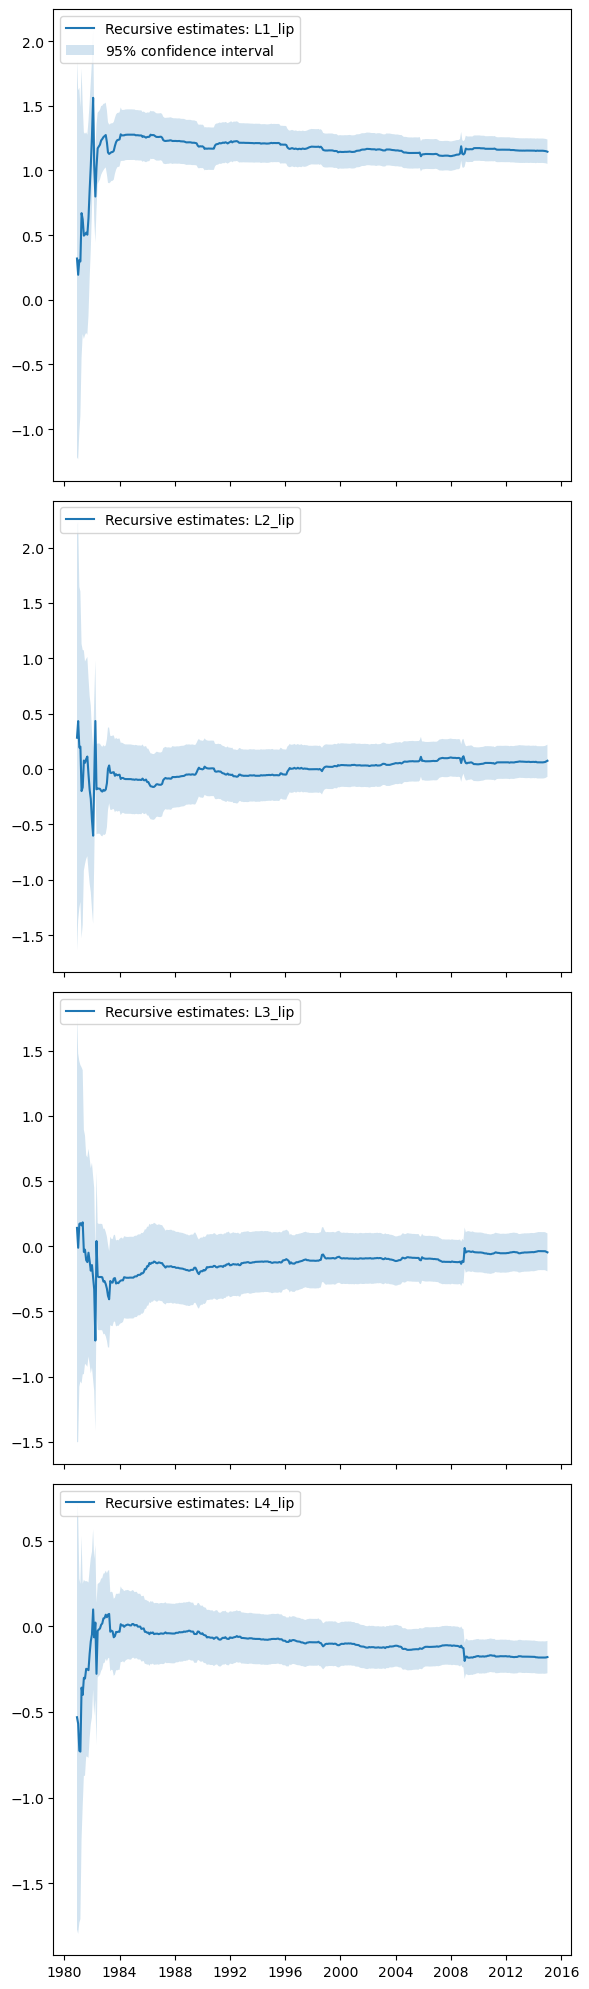

In [17]:
#time/constant
result_rec.plot_recursive_coefficient(range(0,2), figsize=(6,4));
#lag123 
result_rec.plot_recursive_coefficient(range(2,6), figsize=(6,20));

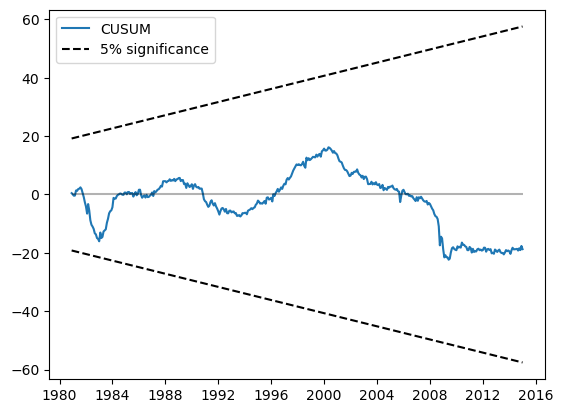

In [18]:
fig = result_rec.plot_cusum()

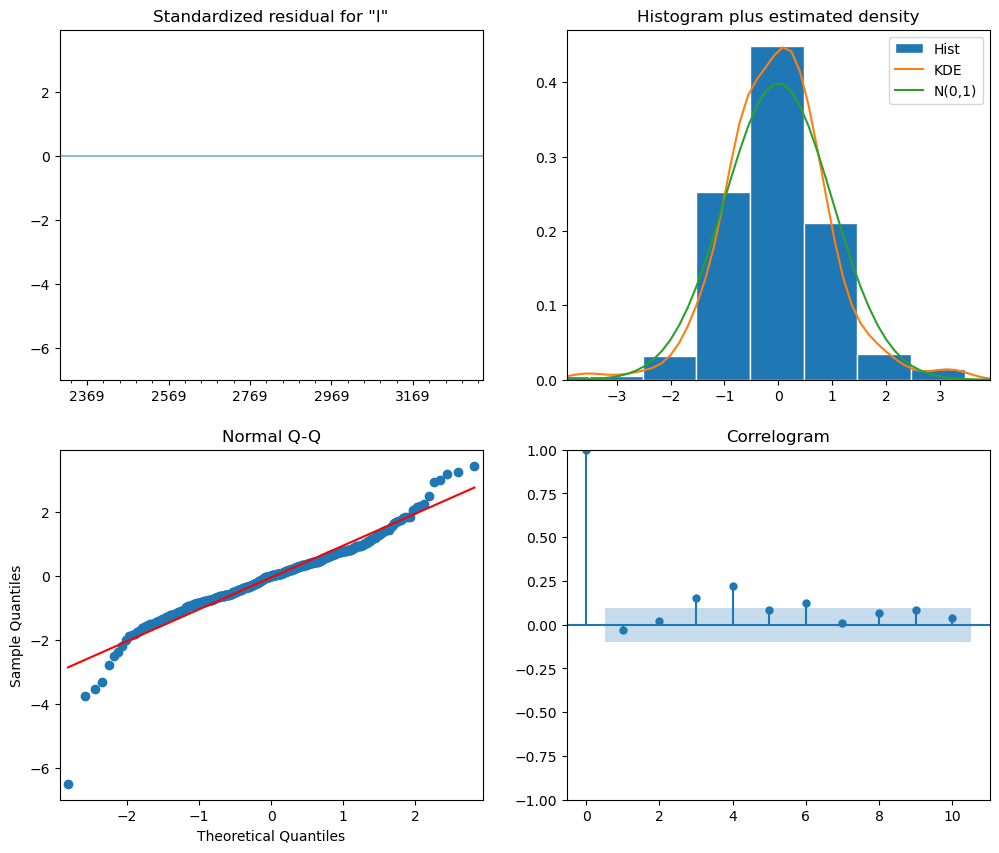

In [19]:
fig = result_rec.plot_diagnostics(figsize=(12,10))

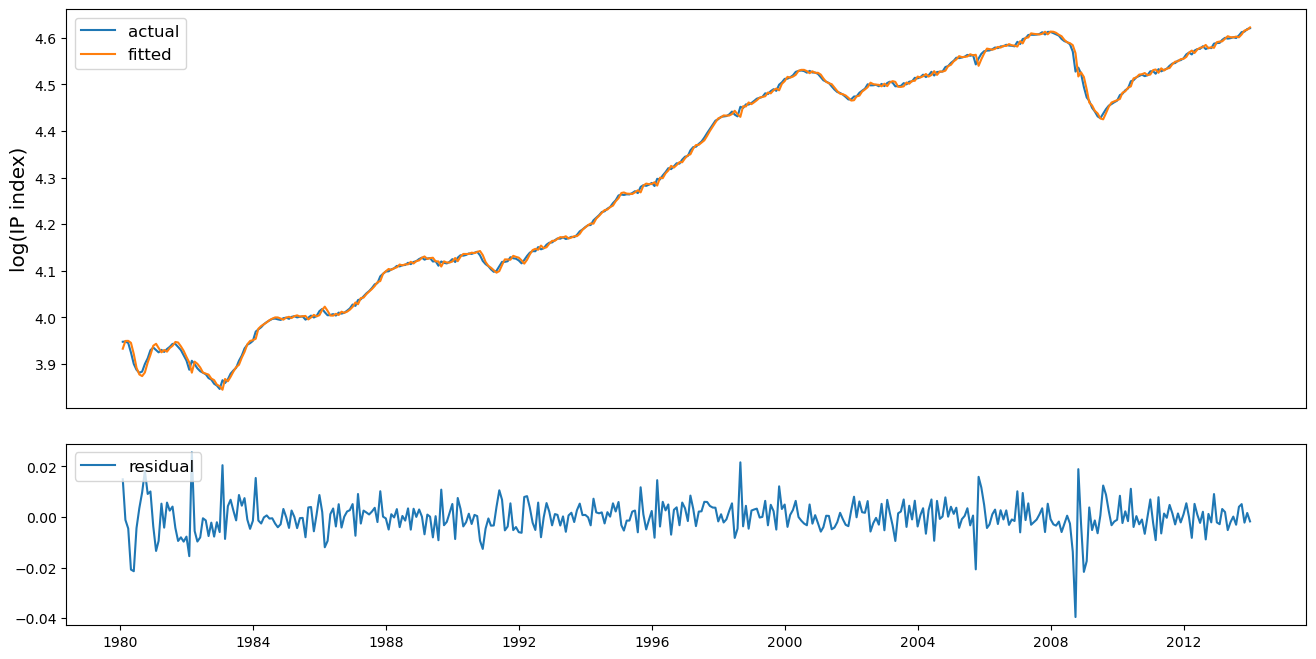

In [20]:
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(3, 1)
ax1 = fig.add_subplot(gs[:2])
ax2 = fig.add_subplot(gs[2], sharex=ax1)

# Plots dependent variable Y and fitted values in the upper panel
ax1.plot(Y, label = 'actual')
ax1.plot(result_arma2.fittedvalues, label = 'fitted')

# Plots residuals in the lower panel
ax2.plot(result_arma2.resid, '-',label='residual')

ax1.tick_params(bottom=False, labelbottom=False, left=True, labelleft=True)
ax1.set_ylabel('log(IP index)', fontsize = 'x-large')

ax1.legend(loc='upper left', fontsize = 'large')
ax2.legend(loc='upper left', fontsize = 'large')

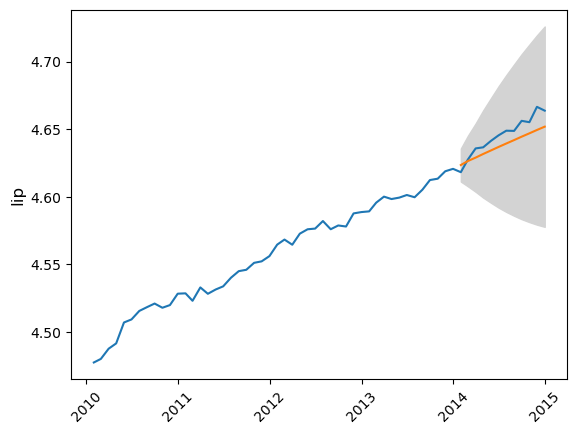

In [21]:
# Define the start and end(exclusive) date of our forecasting period
forecast_start = '2014-01-01'
forecast_end = '2015-01-01'

# Assign values to the exogenous regressors for our forecasting period
X_exog = industrial[['constant','time']][forecast_start:forecast_end]
forecast = result_arma2.get_forecast(12, exog=X_exog)
mean_forecast = forecast.predicted_mean
confidence_interval = forecast.conf_int()

plt.plot(industrial['lip']['2010-01-01':'2015-01-01'])
plt.plot(industrial.index[-12:], mean_forecast.values)
ax = plt.gca()
ax.tick_params(axis = 'x', rotation = 45)
ax.set_ylabel('lip', fontsize = 'large')

# Shade confidence interval
plt.fill_between(industrial.index[-12:], confidence_interval['lower lip'], confidence_interval['upper lip'], color='lightgrey')
plt.show()